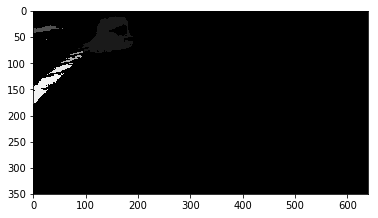

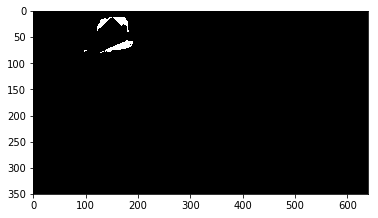

[0 0 0 0 0 0 0 0 0 0]
0.295180722892


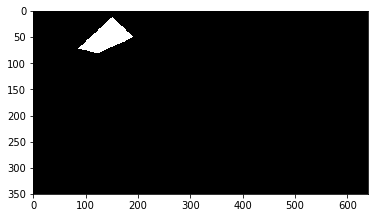

NEW OBJECT:
349
29
0.0830945558739


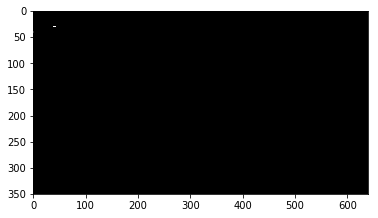

[0 0 0 0 0 0 0 0 0 0]
0.0450704225352


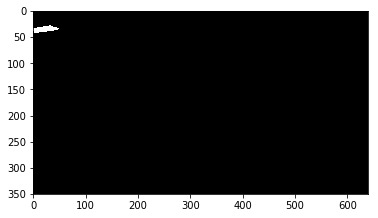

NEW OBJECT:
349
29
0.0830945558739


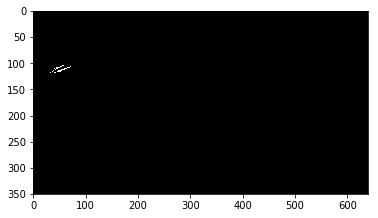

[0 0 0 0 0 0 0 0 0 0]
0.429012345679


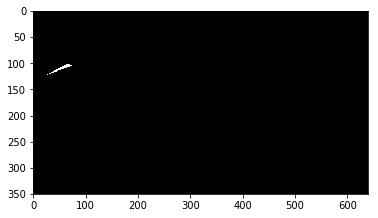

NEW OBJECT:
349
29
0.0830945558739


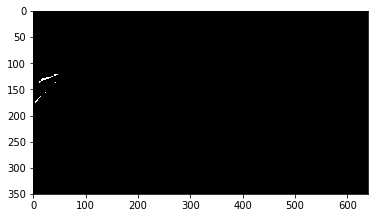

[0 0 0 0 0 0 0 0 0 0]
0.139679715302


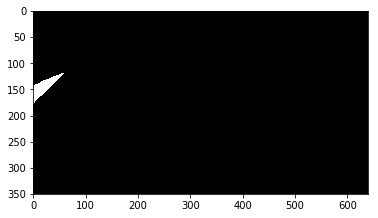

NEW OBJECT:
349
29
0.0830945558739
0.932445049286


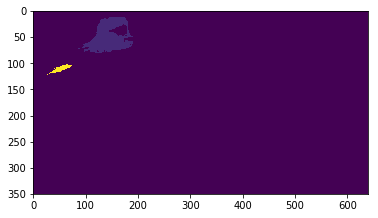

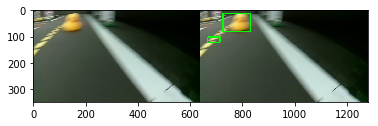

In [42]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

start = time.time()
filename = '/home/juli/savior_bags/13_pics/24.jpg'
im1 = cv2.imread(filename) #reads BGR
im1_cropped = im1[130:,:,:]
im1_orig=np.copy(im1_cropped)
#plt.imshow(im1_cropped); plt.show()

#BREITE DER ENTE EVT AUSNUTZEN!!! oder evt: breite der breitesten stelle vs breite der schmalsten oder so^^
# Convert BGR to HSV
hsv = cv2.cvtColor(im1_cropped, cv2.COLOR_BGR2HSV)
#plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)); plt.show()

#FILTER IMAGE
lower_yellow = np.array([20,75,100])
upper_yellow = np.array([40,255,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
#plt.imshow(mask, cmap='gray'); plt.show()

#evt pre process image through blurring,...
blur2 = cv2.blur(mask,(8,4),0)
super_threshold_indices = blur2 < 1
blur2[super_threshold_indices] = 0 #wie in matlab da wo alle=1 werden sie auf 0 gesetzt!!!
super_threshold_indices = blur2 >= 1
blur2[super_threshold_indices] = 255
#plt.imshow(blur2, cmap='gray'); plt.show()

#--------------------SEGMENT AND EVALUATE-----------------------------------------------------------------
#DIESES MAL UNTEN RECHTS ANFANGEN!!!!

#ÜBERPRÜFUNG OB NACH GELBFILTER WAS ÜBRIGGEBLIEBEN IST:
if(np.sum(mask)!=0):
    final=measure.label(mask)
    plt.imshow(final,cmap='gray'); plt.show()
    i=np.max(final)
    entry=0
    
    #-----------------------FILTER MUSS TIEFENABHÄNGIG WERDEN!!!-------------------------------------------
    for k in range(1,i+1): #durch alle zahlen durchiterieren
        #first only keep large elements then eval their shape
        amount_pixels = np.sum(final == k)
        if (amount_pixels<300): #skip all those who were merged away or have not enough pixels tiefenabh???
            final[(final == k)]=0
        else:
            #DIE BREITE MUSS ICH AUF DER GLEICHEN HÖHE NEHMEN!!!!!!
            B=np.copy(final)
            B[(B != k)]=0
            C=np.nonzero(B)
            ITER=np.reshape(C, (2,-1))
            #print C 
            top_v = np.min(C[0])
            top_u = ITER[1,np.argmin(C[0])]
            bottom_v = np.max(C[0])
            bottom_u = ITER[1,np.argmax(C[0])]
            left_u = np.min(C[1])
            left_v = ITER[0,np.argmin(C[1])]
            right_u = np.max(C[1])
            right_v = ITER[0,np.argmax(C[1])]
            height=bottom_v-top_v #da bottom höhere pixzahl hat!!
            total_width=right_u-left_u
            
            # Now we have a look on this Object and try to find out if it has a rectangular shape
            polygon = [(top_u,top_v),(right_u,right_v),(bottom_u,bottom_v),(left_u,left_v)] 
            
            tupel = np.shape(B)
            img = Image.new('L',(tupel[1],tupel[0]) ,0)
            ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
            subtract_mask = np.array(img)
            subtract_mask = subtract_mask*k
            #print k
            #print subtract_mask[top_v,top_u]
                        
            # Subtract parallelogramm from original image
            subtracted_values = np.subtract(B,subtract_mask)
            subtracted_values[subtracted_values<0]=0
            plt.imshow((subtracted_values),cmap='gray'); plt.show()
            print subtracted_values[300,50:60]
            difference = 1.0*np.sum((subtracted_values))/(amount_pixels*k)
            print difference
            plt.imshow(subtract_mask,cmap='gray'); plt.show()

            #height_left=np.max(ITER[0,(C[1]==left)]) #ACHTUNG:kann mehrere WERTE HABEN
            #width_height_left = np.max(ITER[1,(C[0]==height_left)])
            #WIDTH AT HEIGHT OF LEFT POSITION
            #width_left= width_height_left-left

            #height_right=np.max(ITER[0,(C[1]==right)]) #ACHTUNG:kann mehrere WERTE HABEN
            #width_height_right = np.min(ITER[1,(C[0]==height_right)])
            #WIDTH AT HEIGHT OF RIGHT POSITION
            #width_right= right-width_height_right

            #print width_right
            #print width_left
            #print width_right
            #print height_left
            #print height_right

            print "NEW OBJECT:"
            print bottom
            print width_right
            print 1.0*width_right/bottom

            #WIDTH AT TOP
            #MUSS NOCH ABFRAGE HIN DAMIT MAN NICHT OUT OF BOUNDS LÄUFT
           

            #if (abs(height_left-height_right)>10): #FILTER 1
            #    final[(final == k)]=0
            #if (abs(width_top-width_right)<20): #FILTER 2
            #    final[(final == k)]=0

            if (difference<0.25): #FILTER 3
                final[(final == k)]=0

            else:
                cv2.rectangle(im1_cropped,(np.min(C[1]),np.min(C[0])),(np.max(C[1]),np.max(C[0])),(0,255,0),3)

    #eig box np.min breite und höhe!! if they passed the test!!!!
    #print abc
    end = time.time()
    print(end - start)
    plt.imshow(final); plt.show()
last_img=np.concatenate((im1_orig[:,:,::-1],im1_cropped[:,:,::-1]),axis=1)
plt.imshow(last_img); plt.show()

In [ ]:
#BACKUP
#filter only large elements!!! (many pixels!!!) MUSS TIEFENABHÄNGIG WERDEN!!!
for k in range(1,i+1): #durch alle zahlen durchiterieren
    #first only keep large elements then eval their shape
    if (np.sum((final == k))<1000): #skip all those who were merged away or have not enough pixels
        final[(final == k)]=0
    else:
        #DIE BREITE MUSS ICH AUF DER GLEICHEN HÖHE NEHMEN!!!!!!
        B=np.copy(final)
        B[(B != k)]=0
        C=np.nonzero(B)
        ITER=np.reshape(C, (2,-1))
        #print C        
        height_max = np.max(C[0])-np.min(C[0])
        #width_max = np.max(C[1])-np.min(C[1])
        height_width_max=ITER[0,(C[1]==np.max(C[1]))]
        print height_width_max
        top= np.min(C[0])
        width_top = np.max(ITER[1,(C[0]==top+10)])-np.min(ITER[1,(C[0]==top+10)])
        print width_max
        if (width<50 or height>120):
            final[(final == k)]=0
        else:
            #ÜBERGABE?
            #obst_arr[0,entry]=int(np.max(C[0])-0.5*width)
            #obst_arr[1,entry]=int(np.max(C[1])-0.5*height)
            #obst_arr[2,entry]=int(0.5*width)
            #obst_arr[3,entry]=int(0.5*height)
            entry+=1
            cv2.rectangle(im1_cropped,(np.min(C[1]),np.min(C[0])),(np.max(C[1]),np.max(C[0])),(0,255,0),3)

#eig box np.min breite und höhe!! if they passed the test!!!!
#print abc
end = time.time()
print(end - start)
plt.imshow(final); plt.show()
last_img=np.concatenate((im1_orig[:,:,::-1],im1_cropped[:,:,::-1]),axis=1)
plt.imshow(last_img); plt.show()

In [ ]:
conv = cv2.cvtColor(funky_rgb, cv2.COLOR_RGB2BGR)
cv2.imwrite( 'data/funky_rgb.png', conv)